# TruBridge Patient No-Show Analysis (FINAL)

**Dashboard:** https://patient-noshow-dashboard.vercel.app/  
**GitHub:** https://github.com/ivan-711/Externship-TruBridge  



This notebook merges my original two Colab notebooks into one end-to-end workflow:



- **Step 1 (Data cleaning + feature engineering):** `KaggleV2-May-2016.csv` → `cleaned_appointments.csv` + `publicsafefinalnoshowdataset.csv`  
- **Step 2 (EDA + statistical tests + logistic regression):** analysis on `cleaned_appointments.csv`

## File upload (required)
- Left sidebar → **Files** → **Upload** → `KaggleV2-May-2016.csv`

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
sns.set(style="whitegrid")
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

## Step 1 — Load raw dataset

Upload the raw file to Colab first:

- Left sidebar → **Files** → **Upload** → `KaggleV2-May-2016.csv`

Then run the next cell to load it into pandas.

In [4]:
raw_path = "/content/KaggleV2-May-2016.csv"
df = pd.read_csv(raw_path)

print("Raw dataset shape:", df.shape)
df.head()

Raw dataset shape: (110527, 14)


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [5]:
# Rename columns
df.rename(columns={
    "Neighbourhood": "Neighborhood",
    "Handcap": "Handicap",
    "No-show": "NoShow",
    "PatientId": "PatientID",
    "Hipertension": "Hypertension"
}, inplace=True)

print("Columns after renaming:")
print(df.columns)

Columns after renaming:
Index(['PatientID', 'AppointmentID', 'Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighborhood', 'Scholarship',
       'Hypertension', 'Diabetes', 'Alcoholism', 'Handicap', 'SMS_received', 'NoShow'],
      dtype='object')


In [6]:
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0] if (missing_values > 0).any() else "No missing values found.")

duplicates = df.duplicated().sum()
print("Duplicate rows:", duplicates)

Missing values per column:
No missing values found.
Duplicate rows: 0


In [7]:
df["ScheduledDay"] = pd.to_datetime(df["ScheduledDay"], errors="coerce")
df["AppointmentDay"] = pd.to_datetime(df["AppointmentDay"], errors="coerce")

In [8]:
print("Rows and columns:", df.shape)
print("Data types for each attribute:")
display(df.dtypes)
print(df.head())
print(df.info())

print("Target variable: NoShow (0 = Show, 1 = NoShow)")
print("For other columns: 0 = No, 1= Yes")

Rows and columns: (110527, 14)
Data types for each attribute:


,0
PatientID,float64
AppointmentID,int64
Gender,object
ScheduledDay,"datetime64[ns, UTC]"
AppointmentDay,"datetime64[ns, UTC]"
Age,int64
Neighborhood,object
Scholarship,int64
Hypertension,int64
Diabetes,int64


      PatientID  AppointmentID Gender              ScheduledDay            AppointmentDay  Age       Neighborhood  \
0  2.987250e+13        5642903      F 2016-04-29 18:38:08+00:00 2016-04-29 00:00:00+00:00   62    JARDIM DA PENHA   
1  5.589978e+14        5642503      M 2016-04-29 16:08:27+00:00 2016-04-29 00:00:00+00:00   56    JARDIM DA PENHA   
2  4.262962e+12        5642549      F 2016-04-29 16:19:04+00:00 2016-04-29 00:00:00+00:00   62      MATA DA PRAIA   
3  8.679512e+11        5642828      F 2016-04-29 17:29:31+00:00 2016-04-29 00:00:00+00:00    8  PONTAL DE CAMBURI   
4  8.841186e+12        5642494      F 2016-04-29 16:07:23+00:00 2016-04-29 00:00:00+00:00   56    JARDIM DA PENHA   

   Scholarship  Hypertension  Diabetes  Alcoholism  Handicap  SMS_received NoShow  
0            0             1         0           0         0             0     No  
1            0             0         0           0         0             0     No  
2            0             0         0       

In [9]:
df["NoShow"] = df["NoShow"].map({"No": 0, "Yes": 1})

In [10]:
df["Waiting Days"] = (df["AppointmentDay"] - df["ScheduledDay"]).dt.days


In [11]:
if df["Waiting Days"].isnull().sum() > 0:
    df["Waiting Days"].fillna(df["Waiting Days"].mean(), inplace=True)

print("Missing Waiting Days after fill:", df["Waiting Days"].isnull().sum())

Missing Waiting Days after fill: 0


In [12]:
df = df[df["Waiting Days"] >= 0]
df = df[df["Waiting Days"] <= 365]
df = df[df["Age"] >= 0]

print("Shape after filtering:", df.shape)

Shape after filtering: (71959, 15)


In [13]:
categorical_columns = [
    "Gender", "Neighborhood", "Scholarship", "Hypertension",
    "Diabetes", "Alcoholism", "Handicap", "SMS_received", "NoShow"
]

for col in categorical_columns:
    df[col] = df[col].astype("category")

In [14]:
waiting = df["Waiting Days"].values
age = df["Age"].values

print("Waiting Days - min:", waiting.min())
print("Waiting Days - max:", waiting.max())
print("Age - min:", age.min())
print("Age - max:", age.max())

min_wait = waiting.min()
max_wait = waiting.max()
waiting_norm = (waiting - min_wait) / (max_wait - min_wait)
df["WaitingDays_normalized"] = waiting_norm

min_age = age.min()
max_age = age.max()
age_norm = (age - min_age) / (max_age - min_age)
df["Age_normalized"] = age_norm

df[["Waiting Days", "WaitingDays_normalized", "Age", "Age_normalized"]].head()

Waiting Days - min: 0
Waiting Days - max: 178
Age - min: 0
Age - max: 115


,Waiting Days,WaitingDays_normalized,Age,Age_normalized
5,1,0.005618,76,0.660870
6,1,0.005618,23,0.200000
7,1,0.005618,39,0.339130
9,1,0.005618,19,0.165217
10,1,0.005618,30,0.260870


In [15]:
cleaned_path = "cleaned_appointments.csv"
df.to_csv(cleaned_path, index=False)

print("Saved:", cleaned_path)
print("Final cleaned shape:", df.shape)

Saved: cleaned_appointments.csv
Final cleaned shape: (71959, 17)


In [16]:
public_safe_path = "publicsafefinalnoshowdataset.csv"
df_public = df.drop(columns=["PatientID", "AppointmentID"])
df_public.to_csv(public_safe_path, index=False)

print("Saved:", public_safe_path)
print("Public-safe shape:", df_public.shape)

Saved: publicsafefinalnoshowdataset.csv
Public-safe shape: (71959, 15)


## Step 2 — Load cleaned dataset (for EDA + tests)

This step uses the cleaned output from Step 1.

Run the next cell to load:
- `cleaned_appointments.csv`

In [18]:
df2 = pd.read_csv("cleaned_appointments.csv")
print("Loaded cleaned dataset shape:", df2.shape)
df2.head()

Loaded cleaned dataset shape: (71959, 17)


,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,NoShow,Waiting Days,WaitingDays_normalized,Age_normalized
0,9.598513e+13,5626772,F,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,REPÚBLICA,0,1,0,0,0,0,0,1,0.005618,0.660870
1,7.336882e+14,5630279,F,2016-04-27 15:05:12+00:00,2016-04-29 00:00:00+00:00,23,GOIABEIRAS,0,0,0,0,0,0,1,1,0.005618,0.200000
2,3.449833e+12,5630575,F,2016-04-27 15:39:58+00:00,2016-04-29 00:00:00+00:00,39,GOIABEIRAS,0,0,0,0,0,0,1,1,0.005618,0.339130
3,7.812456e+13,5629123,F,2016-04-27 12:48:25+00:00,2016-04-29 00:00:00+00:00,19,CONQUISTA,0,0,0,0,0,0,0,1,0.005618,0.165217
4,7.345362e+14,5630213,F,2016-04-27 14:58:11+00:00,2016-04-29 00:00:00+00:00,30,NOVA PALESTINA,0,0,0,0,0,0,0,1,0.005618,0.260870


In [19]:
import os
os.makedirs("story_charts", exist_ok=True)
print("Folder ready:", os.path.exists("story_charts"))

Folder ready: True


In [20]:
df2["ScheduledDay"] = pd.to_datetime(df2["ScheduledDay"], errors="coerce")
df2["AppointmentDay"] = pd.to_datetime(df2["AppointmentDay"], errors="coerce")

In [21]:
no_show_rate = df2["NoShow"].astype(int).mean()
show_rate = 1 - no_show_rate
sms_rate = df2["SMS_received"].astype(int).mean()

print("No-show rate:", round(no_show_rate, 4))
print("Show-up rate:", round(show_rate, 4))
print("SMS received rate:", round(sms_rate, 4))

No-show rate: 0.2852
Show-up rate: 0.7148
SMS received rate: 0.4931


In [22]:
contingency_table = pd.crosstab(df2["SMS_received"].astype(int), df2["NoShow"].astype(int))
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square test: SMS_received vs NoShow")
print("Chi2:", round(chi2, 4))
print("p-value:", p)
print("Degrees of freedom:", dof)
contingency_table

Chi-square test: SMS_received vs NoShow
Chi2: 30.5373
p-value: 3.275027505140042e-08
Degrees of freedom: 1


NoShow,0,1
SMS_received,,
0,25739,10738
1,25698,9784


In [23]:
show_wait = df2[df2["NoShow"].astype(int) == 0]["Waiting Days"].astype(float)
noshow_wait = df2[df2["NoShow"].astype(int) == 1]["Waiting Days"].astype(float)

t_stat, p_value = stats.ttest_ind(show_wait, noshow_wait, equal_var=False)

print("Welch t-test: Waiting Days (Show vs NoShow)")
print("t-statistic:", round(t_stat, 4))
print("p-value:", p_value)

print("Median Waiting Days (show):", show_wait.median())
print("Median Waiting Days (no-show):", noshow_wait.median())

Welch t-test: Waiting Days (Show vs NoShow)
t-statistic: -16.1334
p-value: 2.343611521949113e-58
Median Waiting Days (show): 7.0
Median Waiting Days (no-show): 12.0


In [24]:
corr_cols = ["Age", "Waiting Days", "SMS_received", "NoShow"]
corr_matrix = df2[corr_cols].astype(float).corr()

print("Correlation matrix:")
corr_matrix

Correlation matrix:


,Age,Waiting Days,SMS_received,NoShow
Age,1.000000,-0.008608,-0.042537,-0.101042
Waiting Days,-0.008608,1.000000,0.201789,0.060362
SMS_received,-0.042537,0.201789,1.000000,-0.020631
NoShow,-0.101042,0.060362,-0.020631,1.000000


In [25]:
X = df2[["Age_normalized", "WaitingDays_normalized", "SMS_received"]].astype(float)
y = df2["NoShow"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

baseline_acc = (y_test == 0).mean()
model_acc = accuracy_score(y_test, y_pred)

print("Baseline accuracy (all show):", round(baseline_acc, 4))
print("Model accuracy:", round(model_acc, 4))

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(cm)

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))

print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

Baseline accuracy (all show): 0.7148
Model accuracy: 0.7144
Confusion matrix:
[[10275    13]
 [ 4098     6]]

Classification report:
              precision    recall  f1-score   support

           0     0.7149    0.9987    0.8333     10288
           1     0.3158    0.0015    0.0029      4104

    accuracy                         0.7144     14392
   macro avg     0.5153    0.5001    0.4181     14392
weighted avg     0.6011    0.7144    0.5965     14392

Coefficients: [[-1.16085028  1.58629254 -0.16268789]]
Intercept: [-0.59581845]


In [26]:
print('Everything below here is for the EDA section "P2.S4.2 EDA Visualizations"')

print("Missing values by column:")
print(df2.isnull().sum().sort_values(ascending=False))

print("\nMissing values by percentage:")
print((df2.isnull().mean() * 100).sort_values(ascending=False))

print("\nPossible Age outliers (Age < 0 or Age > 100):")
print(df2[(df2["Age"] < 0) | (df2["Age"] > 100)][["Age", "NoShow", "Waiting Days"]].head(10))

Everything below here is for the EDA section "P2.S4.2 EDA Visualizations"
Missing values by column:
PatientID                 0
AppointmentID             0
Gender                    0
ScheduledDay              0
AppointmentDay            0
Age                       0
Neighborhood              0
Scholarship               0
Hypertension              0
Diabetes                  0
Alcoholism                0
Handicap                  0
SMS_received              0
NoShow                    0
Waiting Days              0
WaitingDays_normalized    0
Age_normalized            0
dtype: int64

Missing values by percentage:
PatientID                 0.0
AppointmentID             0.0
Gender                    0.0
ScheduledDay              0.0
AppointmentDay            0.0
Age                       0.0
Neighborhood              0.0
Scholarship               0.0
Hypertension              0.0
Diabetes                  0.0
Alcoholism                0.0
Handicap                  0.0
SMS_received        

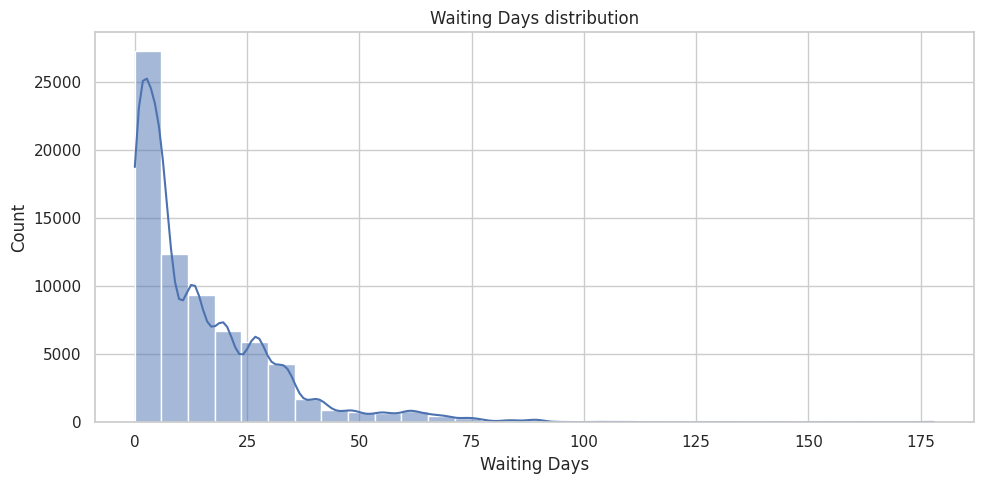

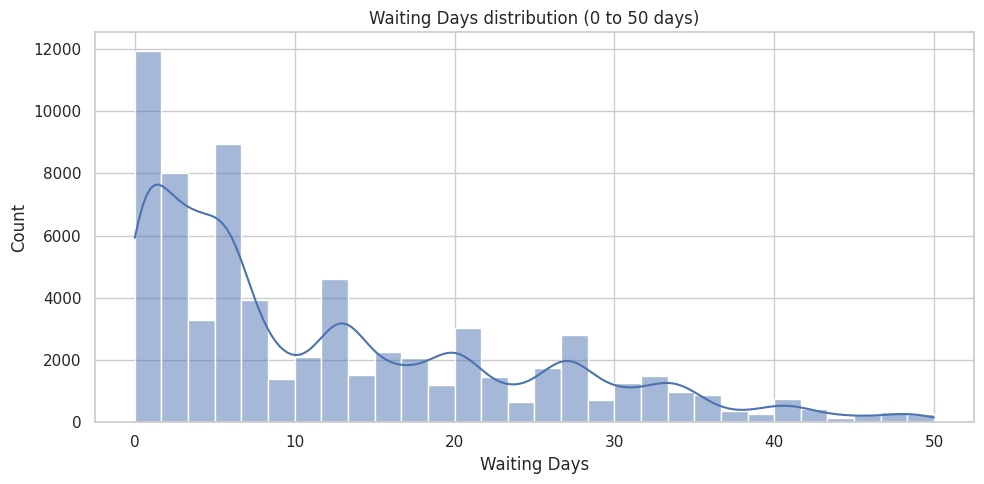

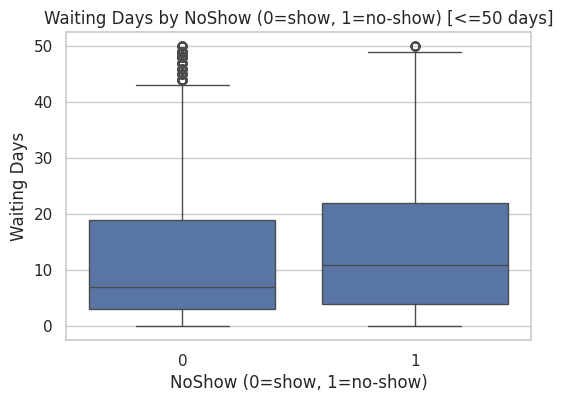

In [27]:
# Waiting Days distribution (full)
plt.figure(figsize=(10,5))
sns.histplot(df2["Waiting Days"], bins=30, kde=True)
plt.title("Waiting Days distribution")
plt.xlabel("Waiting Days")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("story_charts/01_waiting_days_distribution_full.png", dpi=200, bbox_inches="tight")
plt.show()
plt.close()

# Waiting Days distribution (0–50 cap)
plt.figure(figsize=(10,5))
sns.histplot(df2[df2["Waiting Days"] <= 50]["Waiting Days"], bins=30, kde=True)
plt.title("Waiting Days distribution (0 to 50 days)")
plt.xlabel("Waiting Days")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("story_charts/02_waiting_days_distribution_0_50.png", dpi=200, bbox_inches="tight")
plt.show()
plt.close()

# Waiting Days by NoShow (<=50)
df_wd = df2[df2["Waiting Days"] <= 50]
plt.figure(figsize=(6,4))
sns.boxplot(x="NoShow", y="Waiting Days", data=df_wd)
plt.title("Waiting Days by NoShow (0=show, 1=no-show) [<=50 days]")
plt.xlabel("NoShow (0=show, 1=no-show)")
plt.ylabel("Waiting Days")
plt.show()

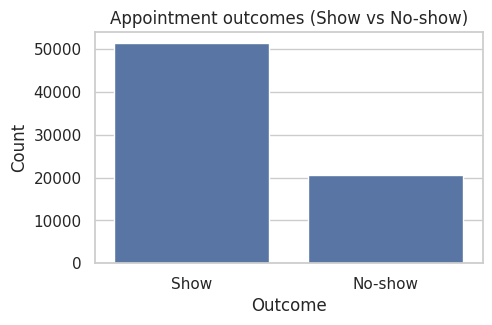

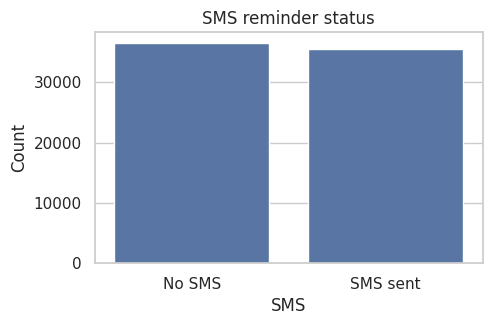

In [28]:
# Bar graph: how many patients showed vs no-show
tmp = df2.copy()
tmp["NoShowLabel"] = tmp["NoShow"].astype(int).map({0: "Show", 1: "No-show"})
tmp["SMS_received"] = tmp["SMS_received"].astype(int)
tmp["SMSLabel"] = tmp["SMS_received"].map({0: "No SMS", 1: "SMS sent"})

plt.figure(figsize=(5,3))
sns.countplot(x="NoShowLabel", data=tmp, order=["Show", "No-show"])
plt.title("Appointment outcomes (Show vs No-show)")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(5,3))
sns.countplot(x="SMSLabel", data=tmp, order=["No SMS", "SMS sent"])
plt.title("SMS reminder status")
plt.xlabel("SMS")
plt.ylabel("Count")
plt.show()

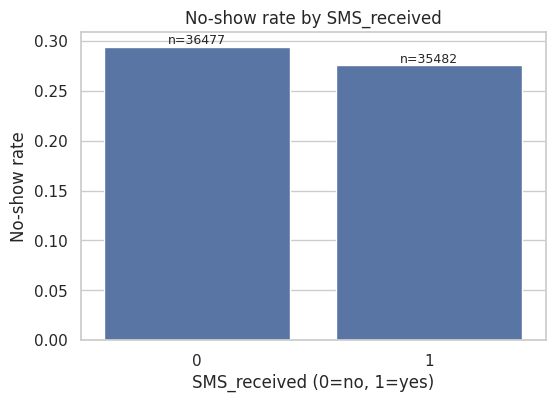

,SMS_received,no_show_rate,n
0,0,0.294377,36477
1,1,0.275745,35482


In [29]:
tmp["NoShow"] = tmp["NoShow"].astype(int)



sms_group = tmp.groupby("SMS_received")["NoShow"].agg(["mean", "count"]).reset_index()

sms_group.columns = ["SMS_received", "no_show_rate", "n"]

plt.figure(figsize=(6, 4))

ax = sns.barplot(x="SMS_received", y="no_show_rate", data=sms_group)

plt.title("No-show rate by SMS_received")

plt.xlabel("SMS_received (0=no, 1=yes)")

plt.ylabel("No-show rate")

for i, row in sms_group.iterrows():
    ax.text(i, row["no_show_rate"], f"n={int(row['n'])}", ha="center", va="bottom", fontsize=9)

plt.show()
sms_group

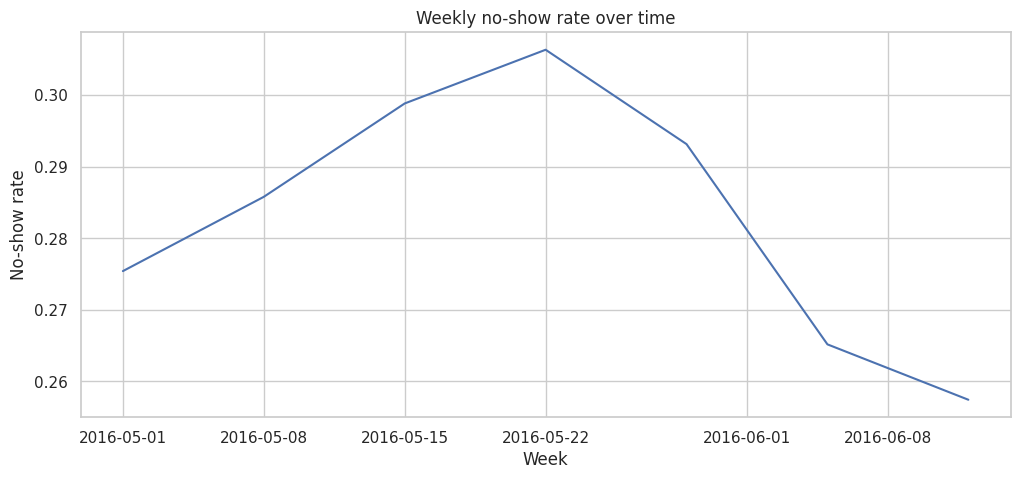

In [30]:
df2["AppointmentDate"] = pd.to_datetime(df2["AppointmentDay"], errors="coerce").dt.date

daily = df2.copy()
daily["NoShow"] = daily["NoShow"].astype(int)

daily = daily.groupby("AppointmentDate")["NoShow"].mean().reset_index()
daily["AppointmentDate"] = pd.to_datetime(daily["AppointmentDate"])
weekly = daily.set_index("AppointmentDate").resample("W")["NoShow"].mean().reset_index()




plt.figure(figsize=(12, 5))
plt.plot(weekly["AppointmentDate"], weekly["NoShow"])
plt.title("Weekly no-show rate over time")
plt.xlabel("Week")
plt.ylabel("No-show rate")
plt.show()

In [34]:
df_age = df2[["Age", "NoShow"]].copy()
df_age["Age"] = pd.to_numeric(df_age["Age"], errors="coerce")
df_age["NoShow"] = pd.to_numeric(df_age["NoShow"], errors="coerce")
df_age = df_age.dropna()
df_age = df_age[(df_age["Age"] >= 0) & (df_age["Age"] <= 110)]



age_bins = [-0.1, 9, 19, 29, 39, 49, 59, 69, 79, 89, 110]
age_labels = ["0-9","10-19","20-29","30-39","40-49","50-59","60-69","70-79","80-89","90+"]




df_age["AgeGroup"] = pd.cut(df_age["Age"], bins=age_bins, labels=age_labels)
age_group_summary = df_age.groupby("AgeGroup", observed=False)["NoShow"].agg(["mean", "count"]).reset_index()
age_group_summary.columns = ["AgeGroup", "no_show_rate", "n"]
age_group_summary


,AgeGroup,no_show_rate,n
0,0-9,0.310400,10058
1,10-19,0.348242,7937
2,20-29,0.351850,8947
3,30-39,0.316501,9842
4,40-49,0.290440,9341
5,50-59,0.237822,10983
6,60-69,0.200167,8383
7,70-79,0.202867,4185
8,80-89,0.220890,2001
9,90+,0.273381,278


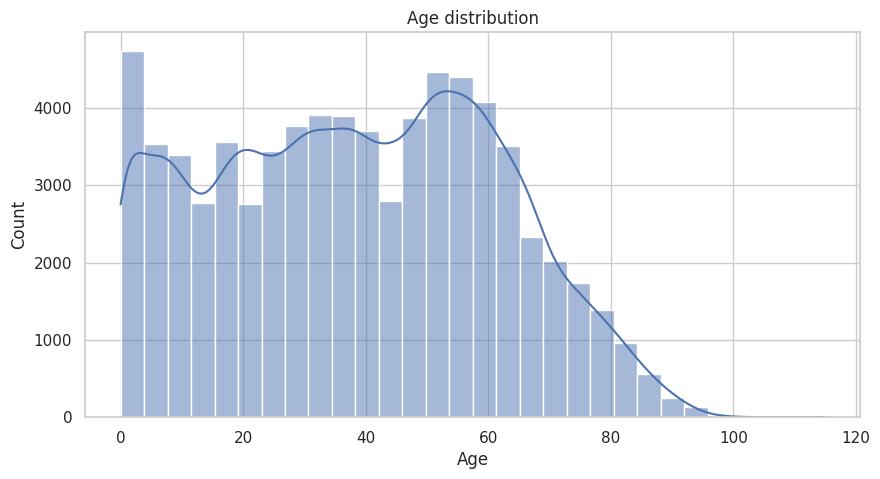

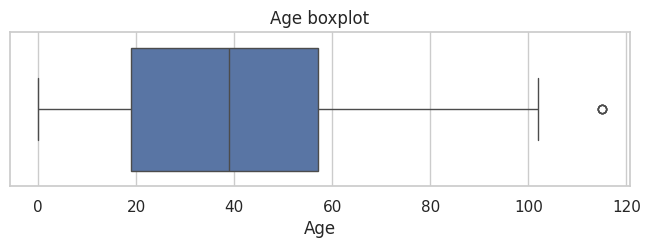

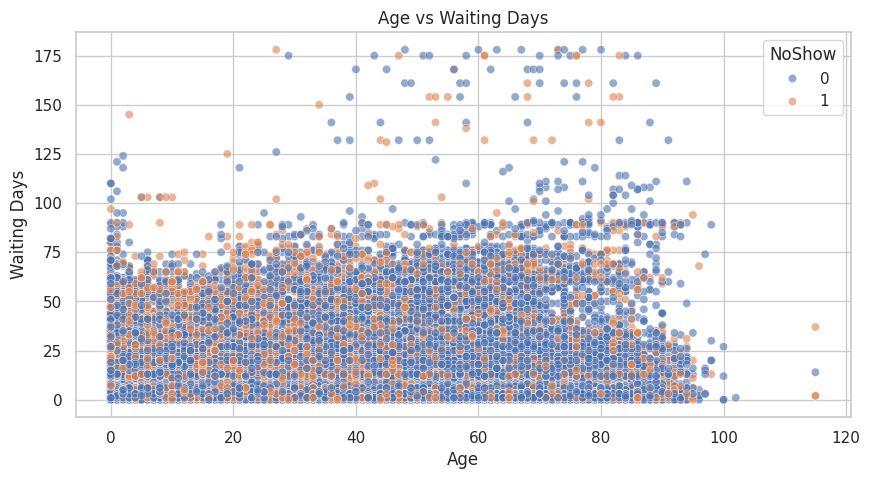

In [32]:
# Age distribution
plt.figure(figsize=(10,5))
sns.histplot(df2["Age"], bins=30, kde=True)
plt.title("Age distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

# Age boxplot
plt.figure(figsize=(8,2))
sns.boxplot(x=df2["Age"])
plt.title("Age boxplot")
plt.xlabel("Age")
plt.show()

# Age vs Waiting Days scatter (hue = NoShow)
df2["NoShow"]  = df2["NoShow"].astype(int)
plt.figure(figsize=(10,5))
sns.scatterplot(
    data=df2,
    x="Age",
    y="Waiting Days",
    hue="NoShow",
    alpha=0.6
)



plt.title("Age vs Waiting Days")
plt.xlabel("Age")
plt.ylabel("Waiting Days")
plt.show()

## Data Quality & Assumptions
- This patient no-show analysis is observational. It shows association, not cause.
- SMS may correlate with higher no-show because reminders can get sent to higher-risk patients.
- Waiting Days is built from timestamps. Rows outside 0–365 days were removed.

## Takeaways
- Overall no-show rate is around 0.20.
- Waiting Days separates shows vs no-shows (median show ~2, median no-show ~11).
- SMS_received groups differ in no-show rate (SMS=1 higher).
- No-show rate changes week to week, so trend monitoring helps.

## Links
- Dashboard: https://patient-noshow-dashboard.vercel.app/
- GitHub: https://github.com/ivan-711/Externship-TruBridge